In [1]:
import numpy as np 
import pandas as pd
import os
print(os.listdir("../input"))
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)

In [3]:
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        tr[col] = tr[col]*(-1)
        te[col] = te[col]*(-1)
    return tr,te

In [4]:
def scale(tr,te):
    for col in tr.columns:
        if col.startswith('var_'):
            mean,std = tr[col].mean(),tr[col].std()
            tr[col] = (tr[col]-mean)/std
            te[col] = (te[col]-mean)/std
    return tr,te

In [5]:
def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

In [6]:
def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

In [7]:
def get_pdfs(tr):
    y = []
    for i in range(204):
        name = 'var_%d'%i
        res = get_pdf(tr,name)
        y.append(res)
    return np.vstack(y)

In [8]:
def print_corr(corr_mat,col,bar=0.5):
    print(col)
    cols = corr_mat.loc[corr_mat[col]>bar,col].index.values
    cols_ = ['var_%s'%(i.split('_')[-1]) for i in cols]
    print(cols)
    #for corr_col in cols:
    #    int_1, int_2 = int(col.split('_')[-1]), int(corr_col.split('_')[-1])
    #    plt.figure(figsize=(10,5))
    #    plt.plot(pdfs[int_1],color='b',label=col)
    #    plt.plot(pdfs[int_2],color='r',label=corr_col)
    #    plt.legend(loc='upper right')
    return cols

In [9]:
%%time
path = '../input/'
tr = pd.read_csv('%s/train.csv'%path)
te = pd.read_csv('%s/test.csv'%path)

CPU times: user 12.1 s, sys: 580 ms, total: 12.6 s
Wall time: 12.6 s


In [10]:
%%time
tr,te = reverse(tr,te)
tr,te = scale(tr,te)
tr["var_200"] = tr["var_108"]*tr["var_198"]*tr["var_162"]*tr["var_111"]
te["var_200"] = te["var_108"]*te["var_198"]*te["var_162"]*te["var_111"]
tr["var_201"] = tr["var_108"]+tr["var_198"]+tr["var_162"]+tr["var_111"]
te["var_201"] = te["var_108"]+te["var_198"]+te["var_162"]+te["var_111"]
tr["var_202"] = tr["var_108"]*tr["var_198"]
te["var_202"] = te["var_108"]*te["var_198"]
tr["var_203"] = tr["var_108"]+tr["var_198"]
te["var_203"] = te["var_108"]+te["var_198"]

CPU times: user 1.02 s, sys: 2.73 ms, total: 1.03 s
Wall time: 1.02 s


In [11]:
tr.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_194,var_195,var_196,var_197,var_198,var_199,var_200,var_201,var_202,var_203
0,train_0,0,0.577100,1.273734,-0.451706,0.833707,-0.235571,0.536429,0.334925,-0.608749,...,0.168704,1.578113,-1.022128,-0.373967,-1.026395,-0.214134,-0.348134,-0.875819,0.684111,-1.692913
1,train_1,0,-0.269958,0.622136,-1.190357,0.688845,-0.790973,-1.539897,-0.244461,0.003525,...,-0.817592,-1.522338,-1.067651,-0.129399,0.825415,-0.505684,1.033831,-0.395274,-1.299868,-0.749391
2,train_2,0,0.681112,0.276066,-0.516987,-0.536515,0.305476,0.511032,-1.769834,0.564748,...,1.151588,-2.297364,1.617902,-0.695139,-0.381448,-0.356681,0.016275,0.477919,0.062728,-0.545895
3,train_3,0,-0.125158,0.129425,0.667574,-0.195354,-0.927990,-0.410671,-0.500632,0.474200,...,1.607865,0.789515,0.959017,1.501741,0.697116,0.543500,0.327930,-0.623566,0.412199,1.288407
4,train_4,0,0.277303,-0.035610,-0.817681,0.077829,-0.738605,-0.955572,-0.613370,-0.791542,...,-1.501098,0.958471,-0.297626,0.645536,0.706316,0.525374,0.013575,0.131672,-0.580998,-0.116259


In [12]:
%%time
pdfs = get_pdfs(tr)

CPU times: user 9.7 s, sys: 287 ms, total: 9.99 s
Wall time: 9.99 s


In [13]:
%%time
df_pdf = pd.DataFrame(pdfs.T,columns=['var_prob_%d'%i for i in range(204)])
corr_mat = df_pdf.corr(method='pearson')

CPU times: user 39 ms, sys: 3.27 ms, total: 42.3 ms
Wall time: 39.1 ms


In [14]:
corr_mat.head()

,var_prob_0,var_prob_1,var_prob_2,var_prob_3,var_prob_4,var_prob_5,var_prob_6,var_prob_7,var_prob_8,var_prob_9,...,var_prob_194,var_prob_195,var_prob_196,var_prob_197,var_prob_198,var_prob_199,var_prob_200,var_prob_201,var_prob_202,var_prob_203
var_prob_0,1.000000,0.854583,0.972078,0.799948,0.752191,0.866316,0.960129,0.237292,0.626824,0.870264,...,0.766543,0.886770,0.735145,0.903237,0.962941,0.467118,0.203786,0.277395,0.190271,0.283059
var_prob_1,0.854583,1.000000,0.819273,0.864657,0.796191,0.980368,0.890947,0.328948,0.628785,0.929723,...,0.871866,0.940488,0.801958,0.897400,0.858108,0.426958,0.205978,0.234653,0.084544,0.231714
var_prob_2,0.972078,0.819273,1.000000,0.775361,0.688469,0.828170,0.931483,0.207203,0.555155,0.842568,...,0.715667,0.848215,0.674816,0.872410,0.935984,0.403145,0.173634,0.288260,0.226468,0.296687
var_prob_3,0.799948,0.864657,0.775361,1.000000,0.583454,0.856993,0.840764,0.283688,0.394153,0.936180,...,0.739694,0.833402,0.603353,0.842384,0.849062,0.242511,0.182517,0.173741,0.180535,0.177026
var_prob_4,0.752191,0.796191,0.688469,0.583454,1.000000,0.828489,0.764516,0.337859,0.827601,0.682816,...,0.862815,0.853776,0.919417,0.767978,0.721840,0.591880,0.261644,0.189770,-0.013408,0.182902


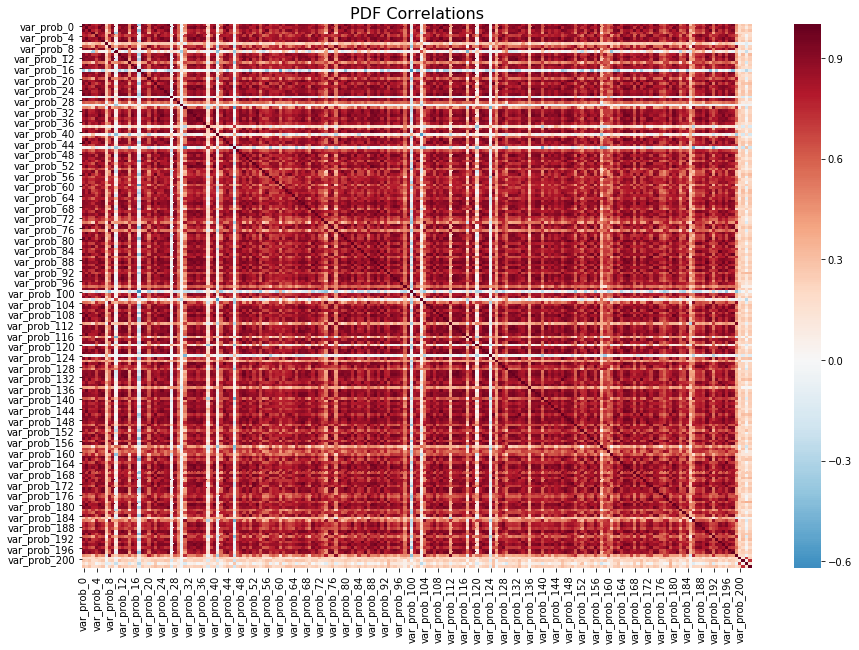

CPU times: user 1.96 s, sys: 1.29 s, total: 3.25 s
Wall time: 1.63 s


In [15]:
%%time
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, cmap='RdBu_r', center=0.0) 
plt.title('PDF Correlations',fontsize=16)
plt.show() 

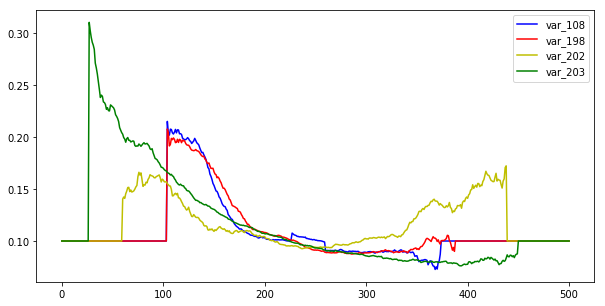

In [23]:
plt.figure(figsize=(10,5))
plt.plot(pdfs[108],color='b',label='var_108')
plt.plot(pdfs[198],color='r',label='var_198')
plt.plot(pdfs[202],color='y',label='var_202')
plt.plot(pdfs[203],color='g',label='var_203')
plt.legend(loc='upper right')

In [17]:
cols = print_corr(corr_mat,'var_prob_108', bar=0.97)

var_prob_108
['var_prob_108' 'var_prob_111' 'var_prob_162' 'var_prob_198']


In [18]:
corr_mat.loc[cols,cols]

,var_prob_108,var_prob_111,var_prob_162,var_prob_198
var_prob_108,1.000000,0.971885,0.979686,0.972147
var_prob_111,0.971885,1.000000,0.978849,0.972949
var_prob_162,0.979686,0.978849,1.000000,0.987393
var_prob_198,0.972147,0.972949,0.987393,1.000000
